In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from statistics import mean
import matplotlib.pyplot as plt
import _pickle as cPickle
from tqdm import tqdm
from scipy.stats import spearmanr

In [2]:
def evaluate(model, inp, target):
    loss_func = torch.nn.MSELoss()
    torch_dataset_val = Data.TensorDataset(inp, target)

    loader_val = Data.DataLoader(
        dataset=torch_dataset_val, 
        batch_size=VAL_BATCH_SIZE, 
        shuffle=False
    )

    dataiter_val = iter(loader_val)
    in_, out_ = dataiter_val.next()

    model.eval()
    pred_scores = model(in_)

    loss = loss_func(pred_scores, out_)
    model.train()
    r_1, _ = spearmanr(
        pred_scores.cpu().detach().numpy()[:,0], 
        out_.cpu().detach().numpy()[:,0], 
        axis=0
    )

    r_2, _ = spearmanr(
        pred_scores.cpu().detach().numpy()[:,1], 
        out_.cpu().detach().numpy()[:,1], 
        axis=0
    )
    
    return r_1, r_2, loss.item()

# train

In [3]:
train_save_path = "datasets/ME/out_features/train_features_NLVR2.pkl"
pooled_dict = cPickle.load(open(train_save_path, 'rb'))
pooled_output_mul = pooled_dict["pooled_output_mul"]
pooled_output_sum = pooled_dict["pooled_output_sum"]
pooled_output_t = pooled_dict["pooled_output_t"]
pooled_output_v = pooled_dict["pooled_output_v"]
concat_pooled_output = pooled_dict["concat_pooled_output"]
targets = pooled_dict["targets"]

In [4]:
test_save_path = "datasets/ME/out_features/test_features_NLVR2.pkl"
pooled_dict_test = cPickle.load(open(test_save_path, 'rb'))
pooled_output_mul_test = pooled_dict_test["pooled_output_mul"]
pooled_output_sum_test = pooled_dict_test["pooled_output_sum"]
pooled_output_t_test = pooled_dict_test["pooled_output_t"]
pooled_output_v_test = pooled_dict_test["pooled_output_v"]
concat_pooled_output_test = pooled_dict_test["concat_pooled_output"]
targets_test = pooled_dict_test["targets"]

In [5]:
class SigLinNet(nn.Module):
    def __init__(self, input_size, 
                 hidden_size_1,
                 hidden_size_2, 
                 hidden_size_3, 
                 num_scores):
        super(SigLinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.Sigmoid(),
            nn.Linear(hidden_size_3, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [6]:
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
EPOCH = 100
lr = 4e-4

In [7]:
torch.manual_seed(42)

torch_dataset = Data.TensorDataset(concat_pooled_output, targets)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

net = SigLinNet(1024*2, 512, 64, 32, 2)
net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
loss_func = torch.nn.MSELoss()

summary = {
    "losses" : [],
    "r1s" : [],
    "r2s" : [],
    "eval_losses" : []
}

net.train()
for _ in tqdm(range(EPOCH)):
    errors = []
    # r1s, r2s, ls = list(), list(), list()
    for step, (batch_in, batch_out) in enumerate(loader):
        optimizer.zero_grad()

        b_in = Variable(batch_in)
        b_out = Variable(batch_out)

        prediction = net(b_in)

        loss = loss_func(prediction, b_out)
        errors.append(loss.item())

        loss.backward()
        optimizer.step()
        
    """r1, r2, _ = evaluate(net, pooled_output_mul_test, targets_test)
    summary["r1s"].append(r1)
    summary["r2s"].append(r2)"""
    summary["losses"].append(mean(errors))

100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


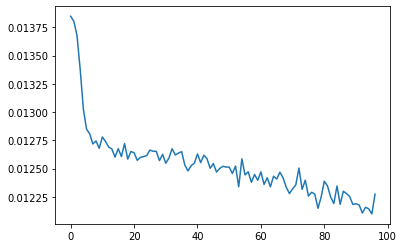

In [8]:
plt.plot(summary["losses"][3:])
#plt.yscale('log')

# test

In [9]:
losses = list()

torch_dataset_val = Data.TensorDataset(concat_pooled_output_test, targets_test)

loader_val = Data.DataLoader(
    dataset=torch_dataset_val, 
    batch_size=VAL_BATCH_SIZE, 
    shuffle=False
)

dataiter_val = iter(loader_val)
in_, out_ = dataiter_val.next()

net.eval()
pred_scores = net(in_)

loss = loss_func(pred_scores, out_)
losses.append(loss.item())

r_1, _ = spearmanr(
    pred_scores.cpu().detach().numpy()[:,0], 
    out_.cpu().detach().numpy()[:,0], 
    axis=0
)

r_2, _ = spearmanr(
    pred_scores.cpu().detach().numpy()[:,1], 
    out_.cpu().detach().numpy()[:,1], 
    axis=0
)

In [10]:
r_1, r_2

(0.41671109171725407, 0.20942198041364313)